
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated


TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable

In [171]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

import pprint
from IPython.display import display as ipydisp    
import collections
import itertools
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.utils import wavg,get_wavg_by
from notebooks.aduriseti_shared.utils import *

NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

#     location_os = ["state", "dma", "operating_system"],
#     location_device=["state", "dma", "device", ],
#     location_os_device = ["state", "dma", "operating_system","device"],
)

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

start_date = NOW - 90*DAY
eval_date = NOW - 30*DAY
end_date = NOW

split2aggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(start_date,end_date,None,traffic_source=GOOGLE,agg_columns=tuple(split_cols+["utc_dt"]))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2aggrps[split] = rps_df
    print(split,rps_df.shape)

Attempting to load environ from: `SM_ENV_BASE`
...Success!!
browser ['browser']


INFO:root:query: SELECT browser,utc_dt, COUNT(session_id)                    ... executed in 31.71 seconds


session uniqueness assummption not satisfied
browser (99, 11)
operating_system ['operating_system']


INFO:root:query: SELECT operating_system,utc_dt, COUNT(session_id)           ... executed in 29.52 seconds


session uniqueness assummption not satisfied
operating_system (460, 11)
device ['device']


INFO:root:query: SELECT device,utc_dt, COUNT(session_id)                     ... executed in 29.0 seconds


session uniqueness assummption not satisfied
device (267, 11)
product ['product']


INFO:root:query: SELECT product,utc_dt, COUNT(session_id)                    ... executed in 29.03 seconds


session uniqueness assummption not satisfied
product (178, 11)
TOD ['dayofweek', 'hourofday']


INFO:root:query: SELECT dayofweek,hourofday,utc_dt, COUNT(session_id)        ... executed in 30.27 seconds


session uniqueness assummption not satisfied
TOD (10164, 11)
dma ['dma']


INFO:root:query: SELECT dma,utc_dt, COUNT(session_id)                        ... executed in 34.16 seconds


session uniqueness assummption not satisfied
dma (18021, 11)
state ['state']


INFO:root:query: SELECT state,utc_dt, COUNT(session_id)                      ... executed in 29.07 seconds


session uniqueness assummption not satisfied
state (4538, 11)
location ['state', 'dma']


INFO:root:query: SELECT state,dma,utc_dt, COUNT(session_id)                  ... executed in 30.21 seconds


session uniqueness assummption not satisfied
location (26015, 11)
dma_os ['dma', 'operating_system']


INFO:root:query: SELECT dma,operating_system,utc_dt, COUNT(session_id)       ... executed in 31.58 seconds


session uniqueness assummption not satisfied
dma_os (69660, 11)
dma_device ['dma', 'device']


INFO:root:query: SELECT dma,device,utc_dt, COUNT(session_id)                 ... executed in 30.76 seconds


session uniqueness assummption not satisfied
dma_device (44463, 11)
dma_os_device ['dma', 'operating_system', 'device']


INFO:root:query: SELECT dma,operating_system,device,utc_dt, COUNT(session_id)... executed in 32.48 seconds


session uniqueness assummption not satisfied
dma_os_device (82797, 11)
state_os ['state', 'operating_system']


INFO:root:query: SELECT state,operating_system,utc_dt, COUNT(session_id)     ... executed in 73.56 seconds


session uniqueness assummption not satisfied
state_os (21795, 11)
state_device ['state', 'device']


INFO:root:query: SELECT state,device,utc_dt, COUNT(session_id)               ... executed in 60.37 seconds


session uniqueness assummption not satisfied
state_device (13138, 11)
state_os_device ['state', 'operating_system', 'device']


INFO:root:query: SELECT state,operating_system,device,utc_dt, COUNT(session_i... executed in 67.03 seconds


session uniqueness assummption not satisfied
state_os_device (30342, 11)
location_os ['state', 'dma', 'operating_system']


INFO:root:query: SELECT state,dma,operating_system,utc_dt, COUNT(session_id) ... executed in 56.69 seconds


session uniqueness assummption not satisfied
location_os (87006, 11)
location_device ['state', 'dma', 'device']


INFO:root:query: SELECT state,dma,device,utc_dt, COUNT(session_id)           ... executed in 30.63 seconds


session uniqueness assummption not satisfied
location_device (57828, 11)
location_os_device ['state', 'dma', 'operating_system', 'device']


INFO:root:query: SELECT state,dma,operating_system,device,utc_dt, COUNT(sessi... executed in 32.87 seconds


session uniqueness assummption not satisfied
location_os_device (100585, 11)


In [191]:
import sklearn.preprocessing
import sklearn.cluster
import sklearn.tree

CLUSTS = 64

from models.utils import wstd
def get_split_factor(rps_df):
    split_attr2unique_vals = {c: rps_df.index.unique(c) for c in rps_df.index.names[:-1]}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    return rps_df.reset_index()[[*new_index_order[:-1],"clust"]].drop_duplicates().__len__()

class AggRPSClust:
    def __init__(self,clusts=CLUSTS):
        self.clusts = clusts
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        self.aggX = X \
            .groupby(X.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(X,"sessions")
            })
        if len(self.aggX) > self.clusts:
            self.aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(self.aggX[["rps"]],sample_weight=self.aggX["sessions"])
        else:
            self.aggX["clust"] = np.arange(len(self.aggX))
        
        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)
        
class TreeRPSClust:
    def __init__(self,clusts=CLUSTS,enc_min_cnt=100,plot=True):
        self.clusts=8
        self.enc_min_cnt = enc_min_cnt
        self.plot = plot
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
            
        Xdf = X .reset_index()[X.index.names]
        ydf = X["rps"]
        wdf = X["sessions"]

        ipydisp(Xdf.isna().sum())
        for c in Xdf.columns:
            too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < self.enc_min_cnt
            Xdf.loc[too_few_I,c] = np.NaN
        ipydisp(Xdf.isna().sum())
        Xdf = Xdf.iloc[:,:-1]
#         Xdf = Xdf.astype(str).fillna("")

        self.enc_1hot = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore") .fit(Xdf)
        self.enc_features = [*self.enc_1hot.get_feature_names()]
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        y = ydf.fillna(0)
        w = wdf

        self.clf = sklearn.tree.DecisionTreeRegressor(
                            min_samples_leaf=1/self.clusts) \
                        .fit(X,y,sample_weight=wdf)
        print(sklearn.tree.export_text(self.clf,feature_names=self.enc_features))
        
        yhat = self.clf.predict(X)
        print("Tree RPS MAE:",(y - yhat).abs().mean())

        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        Xdf = X .reset_index()[X.index.names].iloc[:,:-1]
#         X = self.enc_1hot.transform(Xdf.astype(str).fillna(""))
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        return self.clf.apply(X)
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class KpiCorrClust:
    def __init__(self,clusts=CLUSTS,kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        
        aggX = X.groupby(X.index.names[:-1]) \
            [["sessions","revenue"]].sum()
        aggX[self.kpis] = X.groupby(X.index.names[:-1]) \
            .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
        buckets = aggX.index.values

        min_date = X.index.unique("utc_dt").min()
        max_date = X.index.unique("utc_dt").max()
        date_range = pd.date_range(min_date,max_date)
        kpi_tensor = np.stack(X.loc[bucket,self.kpis] \
                                  .reindex(date_range).fillna(0) \
                                  .rolling(7).mean().fillna(0)
                              for bucket in buckets)
        kpi_tensor = kpi_tensor.transpose(2,0,1)
        D, H, W = kpi_tensor.shape
        kpi_tensor.shape

        if self.plot:
            # i = (kpi_tensor > 0).sum(axis=1)[:,0].argmax()
            # i = kpi_tensor.sum(axis=2)[0,:].argmax()
            i = (kpi_tensor > 1e-3).sum(axis=2)[0].argmax()
            plt.plot(kpi_tensor[0,i,:])
            plt.show()

        kpi_sqrt_tensor = kpi_tensor ** 0.5
        kpi_corps = (kpi_sqrt_tensor @ kpi_sqrt_tensor.transpose(0, 2, 1))
        kpi_coprs = np.log(kpi_corps)
        # kpi_corps = kpi_corps / kpi_corps.max(axis=2).max(axis=1).reshape(D,1,1)
        kpi_corps_df = pd.DataFrame(kpi_corps.mean(axis=0), columns=buckets, index=buckets)

        if len(aggX) > self.clusts:
            aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(kpi_corps_df.values,sample_weight=aggX["sessions"])
        else:
            aggX["clust"] = np.arange(len(aggX))
        self.aggX = aggX
        
#         if plot:
#             for ci in range(CLUSTS):
#                 clust_kpi_df = pd.concat(kpi_df.loc[tuple(uval)] for uval in col_uvals[clust==ci]) \
#                     .reset_index()
#                 print(ci,"rps:",wavg(clust_kpi_df["rps"],clust_kpi_df["sessions"]))
#                 ipydisp(clust_kpi_df[["sessions",'revenue']].sum())
#                 clust_kpi_df \
#                     .groupby("utc_dt")["rps"] \
#                     .agg(get_wavg_by(clust_kpi_df,"sessions")) \
#                     .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
#                     .fillna(0).rolling(7).mean() \
#                     .plot(label=ci,figsize=(15,5))
#             plt.legend()
#             plt.show()
        
        return self
        
    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class HybridCorrTreeClust:
    def __init__(
            self,
            clusts=CLUSTS,enc_min_cnt=100,
            kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.enc_min_cnt = enc_min_cnt
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        self.splitcol2clusterer = {}
        for c in split_idx:
            aggX = X.groupby([c,"utc_dt"]) [["sessions","revenue"]].sum()
            aggX[kpis] = X.groupby([c,"utc_dt"]) \
                .apply(lambda df: wavg(df[kpis],df["sessions"]))
            clusterer = KpiCorrClust(plot=False) .fit(aggX,None)
            clust = clusterer \
                .transform(X.reset_index().set_index([c,"utc_dt"]))
            self.splitcol2clusterer[c] = clusterer
            X[f"{c}_clust"] = clust.values
        
        clust_idx = [f"{c}_clust" for c in split_idx]
#         Xclust = X.groupby([*clust_idx,"utc_dt"]) \
#             [["sessions","revenue"]].sum()
#         Xclust[kpis] = X.groupby([*clust_idx,"utc_dt"]) \
#             .apply(lambda df: wavg(df[kpis],df["sessions"]))

        self.tree_clusterer = TreeRPSClust(plot=False) \
            .fit(X.reset_index().set_index([*clust_idx,"utc_dt"]),None)
        # clusterer = TreeRPSClust() \
        #     .fit(Xclust,None)

        return self
    
    def transform(self,X):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        clust_idx = [f"{c}_clust" for c in split_idx]
        for c,d in zip(split_idx,clust_idx):
            X[d] = self.splitcol2clusterer[c] \
                .transform(X.reset_index().set_index([c,"utc_dt"])) \
                .values
        return self.tree_clusterer \
            .transform(X.reset_index().set_index([*clust_idx,"utc_dt"]))
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

In [192]:
rps_df = split2aggrps["state_os_device"]
X = rps_df
Y = X \
    .reset_index("utc_dt") \
    [["rps","utc_dt"]] \
    .apply(lambda r: pd.Series(
                        np.ones(7) * r["rps"]/7,
                        index=pd.date_range(r["utc_dt"]-6*DAY,r["utc_dt"])),
          axis=1) \
    .stack()

Y.index.names = [*Y.index.names[:-1],"utc_dt"]
Y = Y.groupby(Y.index.names).sum()
X.shape,Y.shape

((30342, 16), (43800,))

{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.006875963137991016,
 'clustered_split_factor': 6,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b73fd30>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008421273263571444}


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,2,0.000000
1.0,308181,2.699133


browser    0
utc_dt     0
dtype: int64

browser    69
utc_dt     69
dtype: int64

|X| (69, 1)
|--- value: [2.36]

Tree RPS MAE: 0.8664436237188955
|X| (69, 1)
|X| (30, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62b73ffa0>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008421273263571444}


,sessions,rps
clust,,
0,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


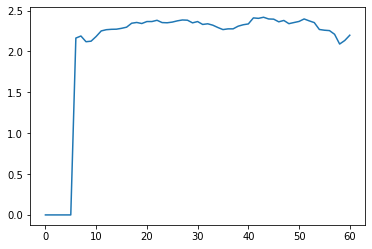

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.006875963137991016,
 'clustered_split_factor': 6,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd644b1b520>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008421273263571444}


,sessions,rps
clust,,
0.0,2,0.000000
1.0,308181,2.699133


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


browser_clust    0
utc_dt           0
dtype: int64

browser_clust    69
utc_dt           69
dtype: int64

|X| (69, 1)
|--- value: [2.36]

Tree RPS MAE: 0.8664436237188955
|X| (69, 1)
|X| (30, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62fb936d0>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008421273263571444}


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308184,2.699107


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.3542171217308651,
 'clustered_split_factor': 11,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b311d60>,
 'fit_shape': (8, 2),
 'split': 'operating_system',
 'split_variance': 0.3542498366119134}


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
1.0,74747,2.582081
2.0,30355,3.072549
3.0,8,0.000000
4.0,67887,3.247716
5.0,127404,2.381436
6.0,7769,2.788285


operating_system    0
utc_dt              0
dtype: int64

operating_system    312
utc_dt              312
dtype: int64

|X| (312, 1)
|--- value: [2.36]

Tree RPS MAE: 0.5373627728373217
|X| (312, 1)
|X| (148, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62fb93df0>,
 'fit_shape': (8, 2),
 'split': 'operating_system',
 'split_variance': 0.3542498366119134}


,sessions,rps
clust,,
0,308174,2.699194


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


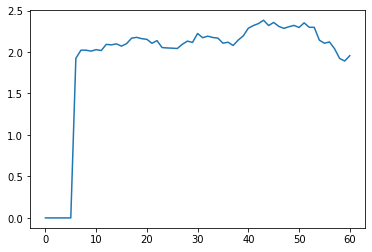

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.3542171217308651,
 'clustered_split_factor': 11,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fbe4c40>,
 'fit_shape': (8, 2),
 'split': 'operating_system',
 'split_variance': 0.3542498366119134}


<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
1.0,74747,2.582081
2.0,30355,3.072549
3.0,8,0.000000
4.0,67887,3.247716
5.0,127404,2.381436
6.0,7769,2.788285


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


operating_system_clust    0
utc_dt                    0
dtype: int64

operating_system_clust    312
utc_dt                    312
dtype: int64

|X| (312, 1)
|--- value: [2.36]

Tree RPS MAE: 0.5373627728373217
|X| (312, 1)
|X| (148, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd64481fa30>,
 'fit_shape': (8, 2),
 'split': 'operating_system',
 'split_variance': 0.3542498366119134}


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308174,2.699194


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122846,
 'clustered_split_factor': 3,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62affeeb0>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38154158080122846}


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,102063,3.229121
1,194858,2.413007
2,11263,2.845949


device    0
utc_dt    0
dtype: int64

device    183
utc_dt    183
dtype: int64

|X| (183, 1)
|--- value: [2.36]

Tree RPS MAE: 0.502195378498665
|X| (183, 1)
|X| (84, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62a7f2730>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38154158080122846}


,sessions,rps
clust,,
0,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


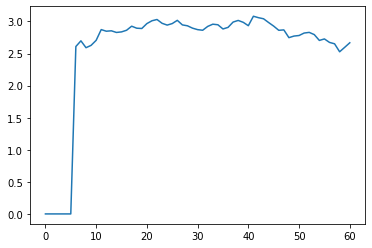

<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122846,
 'clustered_split_factor': 3,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62a7f27c0>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38154158080122846}


,sessions,rps
clust,,
0,102063,3.229121
1,194858,2.413007
2,11263,2.845949


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


device_clust    0
utc_dt          0
dtype: int64

device_clust    183
utc_dt          183
dtype: int64

|X| (183, 1)
|--- value: [2.36]

Tree RPS MAE: 0.502195378498665
|X| (183, 1)
|X| (84, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62f83ad30>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38154158080122846}


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308184,2.699107


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10985787684147583,
 'clustered_split_factor': 2,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b311f40>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10985787684147583}


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,228346,2.634148
1,79838,2.884897


product    0
utc_dt     0
dtype: int64

product    122
utc_dt     122
dtype: int64

|X| (122, 1)
|--- value: [2.36]

Tree RPS MAE: 0.3441346881348094
|X| (122, 1)
|X| (56, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd61abd3430>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10985787684147583}


,sessions,rps
clust,,
0,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


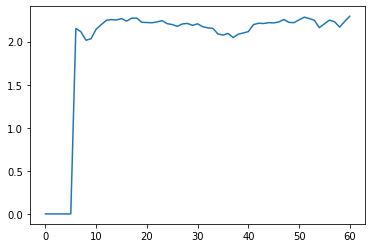

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10985787684147583,
 'clustered_split_factor': 2,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62ac26fd0>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10985787684147583}


<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,228346,2.634148
1,79838,2.884897


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


product_clust    0
utc_dt           0
dtype: int64

product_clust    122
utc_dt           122
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (122, 1)
|--- value: [2.36]

Tree RPS MAE: 0.3441346881348094
|X| (122, 1)
|X| (56, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62b8af310>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10985787684147583}


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308184,2.699107


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.44304807287133063,
 'clustered_split_factor': 309,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b269310>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7009710319329298}


,sessions,rps
clust,,
0,3394,1.900008
1,9676,3.154016
2,3843,1.865637
3,7743,2.982226
4,6708,2.587618
...,...,...
59,7943,3.328636
60,5004,2.370003
61,4672,2.295585


dayofweek    0
hourofday    0
utc_dt       0
dtype: int64

dayofweek       0
hourofday    5516
utc_dt         94
dtype: int64

|X| (6969, 20)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_nan <= 0.50
|   |   |   |--- value: [2.22]
|   |   |--- x1_nan >  0.50
|   |   |   |--- value: [2.55]
|   |--- x0_6.0 >  0.50
|   |   |--- value: [1.88]
|--- x0_0.0 >  0.50
|   |--- value: [1.74]

Tree RPS MAE: 1.1182936603324938
|X| (6969, 20)
|X| (3195, 20)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.21617852697841197,
 'clustered_split_factor': 7,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62fab3af0>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7009710319329298}


,sessions,rps
clust,,
3,269911,2.776792
5,22218,2.307059
6,16055,1.935624


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


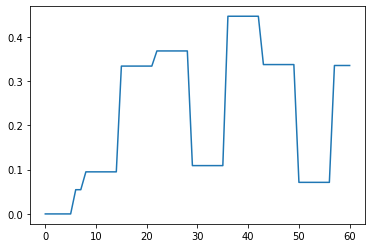

<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4507062863862398,
 'clustered_split_factor': 302,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fab3370>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7009710319329298}


,sessions,rps
clust,,
0,288,2.562257
1,9915,2.882998
2,779,2.711647
3,4574,2.686475
4,3481,2.564397
...,...,...
59,13904,2.894766
60,2901,2.759724
61,1568,2.334891


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust

dayofweek_clust    0
hourofday_clust    0
utc_dt             0
dtype: int64

dayofweek_clust       0
hourofday_clust    2329
utc_dt               94
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (6969, 36)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_nan <= 0.50
|   |   |   |--- value: [2.52]
|   |   |--- x1_nan >  0.50
|   |   |   |--- value: [2.43]
|   |--- x0_6.0 >  0.50
|   |   |--- value: [1.88]
|--- x0_0.0 >  0.50
|   |--- value: [1.74]

Tree RPS MAE: 1.118071730946221
|X| (6969, 36)
|X| (3195, 36)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.21617852697841197,
 'clustered_split_factor': 7,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62fbed340>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7009710319329298}


,sessions,rps
clust,,
3,269911,2.776792
5,22218,2.307059
6,16055,1.935624


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5021688229295601,
 'clustered_split_factor': 64,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b2ff580>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.5833624905232176}


,sessions,rps
clust,,
0,1861,1.684017
1,11244,3.186382
2,305,3.368854
3,2310,2.386320
4,3623,3.065098
...,...,...
59,1112,2.894476
60,10340,2.107194
61,16566,1.929315


dma       0
utc_dt    0
dtype: int64

dma       12379
utc_dt    12379
dtype: int64

|X| (12379, 1)
|--- value: [2.36]

Tree RPS MAE: 2.070137791659506
|X| (12379, 1)
|X| (5642, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62f86ffd0>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.5833624905232176}


,sessions,rps
clust,,
0,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


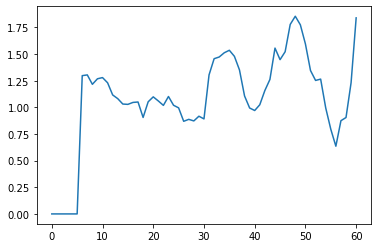

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.48930135205266184,
 'clustered_split_factor': 64,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62c6527f0>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.5833624905232176}


,sessions,rps
clust,,
0,13802,2.831976
1,126,1.889048
2,520,1.294911
3,24,1.339466
4,3820,2.777461
...,...,...
59,691,1.531756
60,12263,2.612180
61,337,3.516719


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


dma_clust    0
utc_dt       0
dtype: int64

dma_clust    1262
utc_dt          0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (12379, 41)
|--- value: [2.36]

Tree RPS MAE: 2.070137791659506
|X| (12379, 41)
|X| (5642, 41)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62b8afb20>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.5833624905232176}


,sessions,rps
clust,,
0,308184,2.699107


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5292176965999936,
 'clustered_split_factor': 51,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62a2c2fd0>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5292176965999936}


,sessions,rps
clust,,
0,421,1.351465
1,4615,3.418335
2,2901,3.063938
3,5735,2.694026
4,29224,1.915710
5,7071,3.557931
6,2235,1.712307
7,1781,2.693920
8,986,4.010353


state     0
utc_dt    0
dtype: int64

state     3110
utc_dt    3110
dtype: int64

|X| (3110, 1)
|--- value: [2.36]

Tree RPS MAE: 1.0815013409205045
|X| (3110, 1)
|X| (1428, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62fbb8df0>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5292176965999936}


,sessions,rps
clust,,
0,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


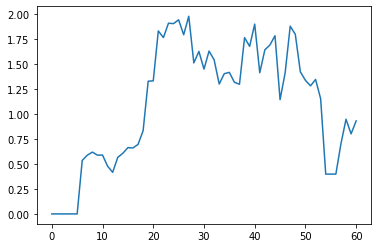

<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5292176965999936,
 'clustered_split_factor': 51,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fbb8730>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5292176965999936}


,sessions,rps
clust,,
0,421,1.351465
1,4615,3.418335
2,2901,3.063938
3,5735,2.694026
4,29224,1.915710
5,7071,3.557931
6,2235,1.712307
7,1781,2.693920
8,986,4.010353


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust    0
utc_dt         0
dtype: int64

state_clust    3110
utc_dt         3110
dtype: int64

|X| (3110, 1)
|--- value: [2.36]

Tree RPS MAE: 1.0815013409205045
|X| (3110, 1)
|X| (1428, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62c645cd0>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5292176965999936}


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308184,2.699107


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.48708491218701705,
 'clustered_split_factor': 336,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62c645f70>,
 'fit_shape': (366, 2),
 'split': 'location',
 'split_variance': 0.6483999697768029}


,sessions,rps
clust,,
0.0,5055,3.003460
1.0,1140,1.316935
2.0,22,3.643182
3.0,211,2.239289
4.0,8522,2.700647
...,...,...
59.0,2085,3.199903
60.0,1015,3.517191
61.0,169,3.657220


state     0
dma       0
utc_dt    0
dtype: int64

state      244
dma       9252
utc_dt       0
dtype: int64

|X| (17744, 113)
|--- x1_nan <= 0.50
|   |--- value: [2.27]
|--- x1_nan >  0.50
|   |--- value: [2.41]

Tree RPS MAE: 2.4965600843128826
|X| (17744, 113)
|X| (8271, 113)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 51,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd61abe4a60>,
 'fit_shape': (366, 2),
 'split': 'location',
 'split_variance': 0.6483999697768029}


,sessions,rps
clust,,
1,308184,2.699107


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


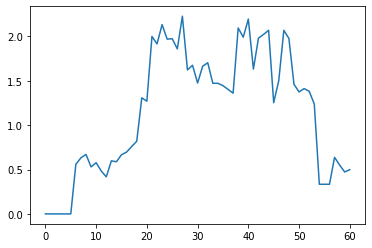

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.46296581029272427,
 'clustered_split_factor': 334,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd61abe4520>,
 'fit_shape': (366, 2),
 'split': 'location',
 'split_variance': 0.6483999697768029}


,sessions,rps
clust,,
0.0,40,8.368250
1.0,1224,3.254475
2.0,258,2.480891
3.0,28938,3.148233
4.0,1355,2.455542
...,...,...
59.0,19,11.855789
60.0,65,8.461089
61.0,54,4.750000


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

state_clust    0
dma_clust      0
utc_dt         0
dtype: int64

state_clust     244
dma_clust      1310
utc_dt            0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (17744, 89)
|--- value: [2.36]

Tree RPS MAE: 2.5033089704583658
|X| (17744, 89)
|X| (8271, 89)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 51,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62ff1fe20>,
 'fit_shape': (366, 2),
 'split': 'location',
 'split_variance': 0.6483999697768029}


,sessions,rps
clust,,
0,308184,2.699107


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.5822362838248608,
 'clustered_split_factor': 250,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62fb7a310>,
 'fit_shape': (1044, 2),
 'split': 'dma_os',
 'split_variance': 0.908811409013491}


,sessions,rps
clust,,
0.0,6460,3.212702
2.0,1482,1.414569
3.0,12,0.500000
4.0,2098,3.756945
5.0,20797,2.451083
...,...,...
59.0,319,3.097643
60.0,3013,2.119758
61.0,14464,2.687819


dma                 0
operating_system    0
utc_dt              0
dtype: int64

dma                 835
operating_system      7
utc_dt                0
dtype: int64

|X| (47488, 204)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- value: [2.21]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [1.98]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.67]
|--- x1_Windows >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 3.0670833330287928
|X| (47488, 204)
|X| (22172, 204)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (4, 2),
 'cluster_variance': 0.35259569021095877,
 'clustered_split_factor': 12,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62b25f880>,
 'fit_shape': (1044, 2),
 'split': 'dma_os',
 'split_variance': 0.908811409013491}


,sessions,rps
clust,,
3,82528,2.601203
4,127404,2.381436
5,30355,3.072549
6,67887,3.247716


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


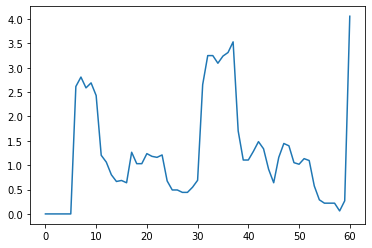

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.41902803670895855,
 'clustered_split_factor': 288,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fb7aa30>,
 'fit_shape': (1044, 2),
 'split': 'dma_os',
 'split_variance': 0.908811409013491}


,sessions,rps
clust,,
0.0,24008,3.428905
1.0,1446,2.508719
2.0,570,2.561764
3.0,9909,2.415266
4.0,275,2.376408
...,...,...
59.0,106,1.600799
60.0,571,2.790658
61.0,5746,3.660626


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust                 0
operating_system_clust    0
utc_dt                    0
dtype: int64

dma_clust                 452
operating_system_clust      7
utc_dt                      0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (47488, 63)
|--- x1_4.0 <= 0.50
|   |--- x1_2.0 <= 0.50
|   |   |--- x1_5.0 <= 0.50
|   |   |   |--- value: [2.21]
|   |   |--- x1_5.0 >  0.50
|   |   |   |--- value: [1.98]
|   |--- x1_2.0 >  0.50
|   |   |--- value: [2.67]
|--- x1_4.0 >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 3.0670833330287928
|X| (47488, 63)
|X| (22172, 63)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (4, 2),
 'cluster_variance': 0.35259569021095877,
 'clustered_split_factor': 12,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62fb7adf0>,
 'fit_shape': (1044, 2),
 'split': 'dma_os',
 'split_variance': 0.908811409013491}


,sessions,rps
clust,,
3,82528,2.601203
4,127404,2.381436
5,30355,3.072549
6,67887,3.247716


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6236183039453379,
 'clustered_split_factor': 148,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62a7f21f0>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.8441221908133557}


,sessions,rps
clust,,
0.0,7968,2.987490
1.0,1,0.000000
2.0,17382,2.020618
3.0,12,5.170000
4.0,510,4.090366
...,...,...
59.0,19558,2.544889
60.0,4102,3.713267
61.0,7420,3.629390


dma       0
device    0
utc_dt    0
dtype: int64

dma       1750
device       0
utc_dt       0
dtype: int64

|X| (30447, 190)
|--- x1_DESK <= 0.50
|   |--- x1_PHON <= 0.50
|   |   |--- value: [2.44]
|   |--- x1_PHON >  0.50
|   |   |--- value: [2.02]
|--- x1_DESK >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 2.8673020060564665
|X| (30447, 190)
|X| (14016, 190)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd644855df0>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.8441221908133557}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


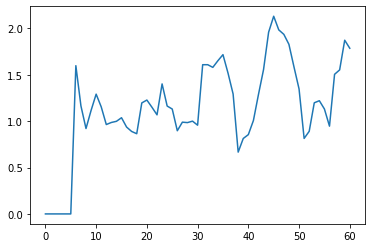

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5156076642158455,
 'clustered_split_factor': 154,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62b73f5e0>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.8441221908133557}


,sessions,rps
clust,,
0.0,274,3.486095
1.0,1949,2.719683
2.0,387,2.997067
3.0,57250,2.827855
4.0,249,2.189682
...,...,...
59.0,18596,1.982102
60.0,28,0.959286
61.0,65,2.268154


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust       0
device_clust    0
utc_dt          0
dtype: int64

dma_clust       1192
device_clust       0
utc_dt             0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (30447, 51)
|--- x1_0.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- value: [2.44]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.02]
|--- x1_0.0 >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 2.8673020060564665
|X| (30447, 51)
|X| (14016, 51)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 3,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62cc64040>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.8441221908133557}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (60, 2),
 'cluster_variance': 0.5815189634941249,
 'clustered_split_factor': 434,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62fbff9d0>,
 'fit_shape': (1840, 2),
 'split': 'dma_os_device',
 'split_variance': 1.120491116120675}


,sessions,rps
clust,,
0.0,808,3.224070
1.0,1,0.000000
2.0,6292,3.662965
3.0,2,0.000000
4.0,21,1.607143
5.0,7,0.000000
6.0,14064,2.309356
7.0,77,5.698571
8.0,13,1.293846


dma                 0
operating_system    0
device              0
utc_dt              0
dtype: int64

dma                 749
operating_system      7
device                0
utc_dt                0
dtype: int64

|X| (56185, 208)
|--- x2_DESK <= 0.50
|   |--- x2_PHON <= 0.50
|   |   |--- value: [2.44]
|   |--- x2_PHON >  0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [1.98]
|--- x2_DESK >  0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- value: [3.01]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 3.2932560761355685
|X| (56185, 208)
|X| (26612, 208)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.386284250974833,
 'clustered_split_factor': 22,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd644940b20>,
 'fit_shape': (1840, 2),
 'split': 'dma_os_device',
 'split_variance': 1.120491116120675}


,sessions,rps
clust,,
2,11263,2.845949
4,67618,2.473588
5,127230,2.381001
7,72439,3.284192
8,29624,3.094457


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


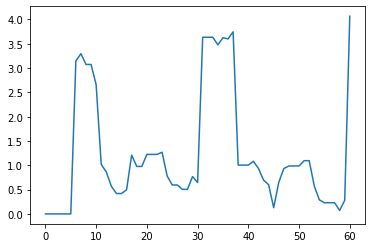

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.43814296891494253,
 'clustered_split_factor': 440,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fa246a0>,
 'fit_shape': (1840, 2),
 'split': 'dma_os_device',
 'split_variance': 1.120491116120675}


,sessions,rps
clust,,
0.0,154,1.939870
1.0,3309,2.911234
2.0,578,3.584325
3.0,30698,2.712295
4.0,4361,2.402242
...,...,...
59.0,533,2.846630
60.0,574,2.942369
61.0,1628,2.345103


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust                 0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

dma_clust                 523
operating_system_clust      7
device_clust                0
utc_dt                      0
dtype: int64

|X| (56185, 65)
|--- x2_0.0 <= 0.50
|   |--- x2_1.0 <= 0.50
|   |   |--- value: [2.44]
|   |--- x2_1.0 >  0.50
|   |   |--- x1_5.0 <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x1_5.0 >  0.50
|   |   |   |--- value: [1.98]
|--- x2_0.0 >  0.50
|   |--- x1_2.0 <= 0.50
|   |   |--- value: [3.01]
|   |--- x1_2.0 >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 3.293256076135569
|X| (56185, 65)
|X| (26612, 65)


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.386284250974833,
 'clustered_split_factor': 22,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd645e61070>,
 'fit_shape': (1840, 2),
 'split': 'dma_os_device',
 'split_variance': 1.120491116120675}


,sessions,rps
clust,,
2,11263,2.845949
4,67618,2.473588
5,127230,2.381001
7,72439,3.284192
8,29624,3.094457


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.6380393387031347,
 'clustered_split_factor': 164,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62fab3820>,
 'fit_shape': (263, 2),
 'split': 'state_os',
 'split_variance': 0.7103909462922312}


,sessions,rps
clust,,
0.0,1209,3.079179
1.0,9353,2.344839
2.0,14045,2.806585
3.0,272,1.491905
4.0,6826,3.432806
...,...,...
59.0,11049,2.546822
60.0,3164,2.798734
61.0,3727,3.479756


state               0
operating_system    0
utc_dt              0
dtype: int64

state               0
operating_system    7
utc_dt              0
dtype: int64

|X| (14925, 57)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- x1_iPadOS <= 0.50
|   |   |   |   |--- value: [2.19]
|   |   |   |--- x1_iPadOS >  0.50
|   |   |   |   |--- value: [2.36]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [1.98]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.67]
|--- x1_Windows >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 2.106076946938824
|X| (14925, 57)
|X| (6870, 57)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.3539742266074604,
 'clustered_split_factor': 12,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62b0667c0>,
 'fit_shape': (263, 2),
 'split': 'state_os',
 'split_variance': 0.7103909462922312}


,sessions,rps
clust,,
4,74759,2.581761
5,7769,2.788285
6,127404,2.381436
7,30355,3.072549
8,67887,3.247716


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


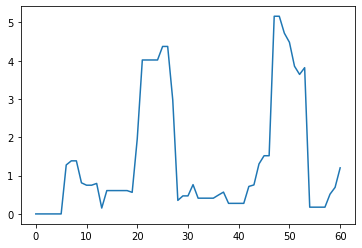

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.5744230503781728,
 'clustered_split_factor': 164,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62b73f6a0>,
 'fit_shape': (263, 2),
 'split': 'state_os',
 'split_variance': 0.7103909462922312}


,sessions,rps
clust,,
0.0,15232,2.390729
1.0,500,1.865200
2.0,20,0.683500
3.0,2452,1.948494
4.0,7967,3.004827
...,...,...
59.0,56,4.745000
60.0,336,2.954372
61.0,189,3.556424


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


state_clust               0
operating_system_clust    0
utc_dt                    0
dtype: int64

state_clust               0
operating_system_clust    7
utc_dt                    0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (14925, 57)
|--- x1_4.0 <= 0.50
|   |--- x1_2.0 <= 0.50
|   |   |--- x1_5.0 <= 0.50
|   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |--- value: [2.19]
|   |   |   |--- x1_6.0 >  0.50
|   |   |   |   |--- value: [2.36]
|   |   |--- x1_5.0 >  0.50
|   |   |   |--- value: [1.98]
|   |--- x1_2.0 >  0.50
|   |   |--- value: [2.67]
|--- x1_4.0 >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 2.106076946938823
|X| (14925, 57)
|X| (6870, 57)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.3539742266074604,
 'clustered_split_factor': 12,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd644855670>,
 'fit_shape': (263, 2),
 'split': 'state_os',
 'split_variance': 0.7103909462922312}


,sessions,rps
clust,,
4,74759,2.581761
5,7769,2.788285
6,127404,2.381436
7,30355,3.072549
8,67887,3.247716


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6686970648377324,
 'clustered_split_factor': 105,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62faab340>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.7071996508276521}


,sessions,rps
clust,,
0,7865,2.510254
1,4685,3.371820
2,20,4.216000
3,7657,1.690985
4,4968,3.660243
...,...,...
59,13707,2.877448
60,561,1.595536
61,424,2.844430


state     0
device    0
utc_dt    0
dtype: int64

state     0
device    0
utc_dt    0
dtype: int64

|X| (9006, 54)
|--- x1_DESK <= 0.50
|   |--- x1_PHON <= 0.50
|   |   |--- value: [2.44]
|   |--- x1_PHON >  0.50
|   |   |--- value: [2.02]
|--- x1_DESK >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 1.9352546755260844
|X| (9006, 54)
|X| (4132, 54)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd64467f190>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.7071996508276521}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


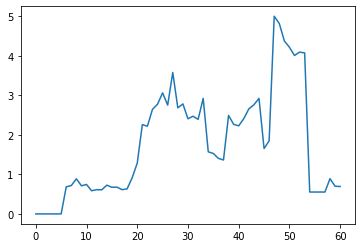

<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6279283007451718,
 'clustered_split_factor': 90,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fb33430>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.7071996508276521}


,sessions,rps
clust,,
0,197,4.476265
1,1146,1.408305
2,13115,2.247783
3,221,1.182986
4,10431,3.605218
...,...,...
59,91,3.213527
60,212,3.131295
61,99,2.529697


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust     0
device_clust    0
utc_dt          0
dtype: int64

state_clust     0
device_clust    0
utc_dt          0
dtype: int64

|X| (9006, 54)
|--- x1_0.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- value: [2.44]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.02]
|--- x1_0.0 >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 1.9352546755260844
|X| (9006, 54)
|X| (4132, 54)


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 3,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62fa2d130>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.7071996508276521}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (61, 2),
 'cluster_variance': 0.6479670132410768,
 'clustered_split_factor': 297,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62fab3130>,
 'fit_shape': (586, 2),
 'split': 'state_os_device',
 'split_variance': 0.8139730821082486}


,sessions,rps
clust,,
0.0,3428,4.107653
1.0,3,0.000000
2.0,5064,1.938481
3.0,3,8.556667
4.0,13,7.218462
...,...,...
59.0,29230,2.881144
60.0,1875,1.624833
61.0,19669,2.329919


state               0
operating_system    0
device              0
utc_dt              0
dtype: int64

state               0
operating_system    7
device              0
utc_dt              0
dtype: int64

|X| (20709, 60)
|--- x2_DESK <= 0.50
|   |--- x2_PHON <= 0.50
|   |   |--- x1_iPadOS <= 0.50
|   |   |   |--- value: [2.57]
|   |   |--- x1_iPadOS >  0.50
|   |   |   |--- value: [2.37]
|   |--- x2_PHON >  0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [1.98]
|--- x2_DESK >  0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_Windows <= 0.50
|   |   |   |--- value: [3.15]
|   |   |--- x1_Windows >  0.50
|   |   |   |--- value: [3.00]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 2.694633849531416
|X| (20709, 60)
|X| (9633, 60)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.3923757311640446,
 'clustered_split_factor': 22,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62b73f910>,
 'fit_shape': (586, 2),
 'split': 'state_os_device',
 'split_variance': 0.8139730821082486}


,sessions,rps
clust,,
3,3623,2.920605
4,7640,2.810546
6,67618,2.473588
7,127230,2.381001
10,4667,3.819971
11,67772,3.247297
12,29624,3.094457


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


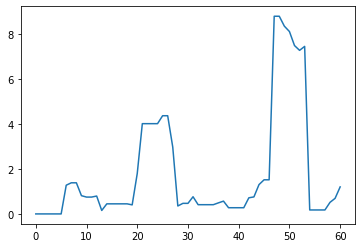

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5720468314042008,
 'clustered_split_factor': 281,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62fb7a6a0>,
 'fit_shape': (586, 2),
 'split': 'state_os_device',
 'split_variance': 0.8139730821082486}


,sessions,rps
clust,,
0.0,21581,2.535258
1.0,59,3.401708
2.0,8405,1.668643
3.0,349,3.159904
4.0,623,2.454539
...,...,...
59.0,2759,3.293913
60.0,508,2.211938
61.0,36,8.575278


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


state_clust               0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

state_clust               0
operating_system_clust    7
device_clust              0
utc_dt                    0
dtype: int64

|X| (20709, 60)
|--- x2_0.0 <= 0.50
|   |--- x2_1.0 <= 0.50
|   |   |--- x1_6.0 <= 0.50
|   |   |   |--- value: [2.57]
|   |   |--- x1_6.0 >  0.50
|   |   |   |--- value: [2.37]
|   |--- x2_1.0 >  0.50
|   |   |--- x1_5.0 <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x1_5.0 >  0.50
|   |   |   |--- value: [1.98]
|--- x2_0.0 >  0.50
|   |--- x1_2.0 <= 0.50
|   |   |--- x1_4.0 <= 0.50
|   |   |   |--- value: [3.15]
|   |   |--- x1_4.0 >  0.50
|   |   |   |--- value: [3.00]
|   |--- x1_2.0 >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 2.694633849531416
|X| (20709, 60)
|X| (9633, 60)


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.3923757311640446,
 'clustered_split_factor': 22,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd62fa5a700>,
 'fit_shape': (586, 2),
 'split': 'state_os_device',
 'split_variance': 0.8139730821082486}


,sessions,rps
clust,,
3,3623,2.920605
4,7640,2.810546
6,67618,2.473588
7,127230,2.381001
10,4667,3.819971
11,67772,3.247297
12,29624,3.094457


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (61, 2),
 'cluster_variance': 0.5692596375907023,
 'clustered_split_factor': 1455,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62f7cd580>,
 'fit_shape': (1666, 2),
 'split': 'location_os',
 'split_variance': 1.09683788840568}


,sessions,rps
clust,,
0.0,12658,2.281046
2.0,7,0.000000
3.0,605,3.356121
4.0,3,0.000000
5.0,968,1.636967
...,...,...
59.0,48,6.914375
60.0,70,0.930545
61.0,7723,3.149386


state               0
dma                 0
operating_system    0
utc_dt              0
dtype: int64

state                 0
dma                 837
operating_system      7
utc_dt                0
dtype: int64

|X| (58880, 255)
|--- x2_Windows <= 0.50
|   |--- x2_Mac OS X <= 0.50
|   |   |--- x2_iOS <= 0.50
|   |   |   |--- value: [2.21]
|   |   |--- x2_iOS >  0.50
|   |   |   |--- value: [1.98]
|   |--- x2_Mac OS X >  0.50
|   |   |--- value: [2.67]
|--- x2_Windows >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 3.2433569751130573
|X| (58880, 255)
|X| (28126, 255)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (4, 2),
 'cluster_variance': 0.35259569021095877,
 'clustered_split_factor': 268,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd62b73fee0>,
 'fit_shape': (1666, 2),
 'split': 'location_os',
 'split_variance': 1.09683788840568}


,sessions,rps
clust,,
3,82528,2.601203
4,127404,2.381436
5,30355,3.072549
6,67887,3.247716


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


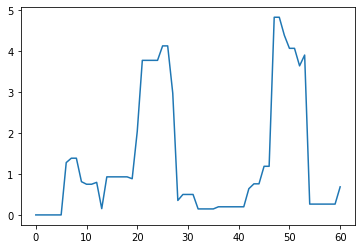

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.43277901932051016,
 'clustered_split_factor': 1540,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62f85d760>,
 'fit_shape': (1666, 2),
 'split': 'location_os',
 'split_variance': 1.09683788840568}


,sessions,rps
clust,,
0.0,344,2.478195
1.0,1418,2.708512
2.0,1027,3.344573
3.0,10590,2.994867
4.0,1622,2.623235
...,...,...
59.0,11088,2.225367
60.0,309,3.381165
61.0,6531,2.224326


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

state_clust               0
dma_clust                 0
operating_system_clust    0
utc_dt                    0
dtype: int64

state_clust                 0
dma_clust                 478
operating_system_clust      7
utc_dt                      0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (58880, 114)
|--- x2_4.0 <= 0.50
|   |--- x2_2.0 <= 0.50
|   |   |--- x2_5.0 <= 0.50
|   |   |   |--- value: [2.21]
|   |   |--- x2_5.0 >  0.50
|   |   |   |--- value: [1.98]
|   |--- x2_2.0 >  0.50
|   |   |--- value: [2.67]
|--- x2_4.0 >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 3.2433569751130573
|X| (58880, 114)
|X| (28126, 114)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (4, 2),
 'cluster_variance': 0.35259569021095877,
 'clustered_split_factor': 268,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd644ad4ee0>,
 'fit_shape': (1666, 2),
 'split': 'location_os',
 'split_variance': 1.09683788840568}


,sessions,rps
clust,,
3,82528,2.601203
4,127404,2.381436
5,30355,3.072549
6,67887,3.247716


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (61, 2),
 'cluster_variance': 0.6084712595288079,
 'clustered_split_factor': 894,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62b269d00>,
 'fit_shape': (1012, 2),
 'split': 'location_device',
 'split_variance': 0.9617579547916049}


,sessions,rps
clust,,
0.0,22662,2.664559
2.0,4,5.502500
3.0,3753,3.635080
4.0,261,3.148996
5.0,71,2.548873
...,...,...
59.0,14527,2.571018
60.0,180,3.923501
61.0,246,2.671707


state     0
dma       0
device    0
utc_dt    0
dtype: int64

state        0
dma       1595
device       0
utc_dt       0
dtype: int64

|X| (39334, 243)
|--- x2_DESK <= 0.50
|   |--- x2_PHON <= 0.50
|   |   |--- value: [2.44]
|   |--- x2_PHON >  0.50
|   |   |--- value: [2.02]
|--- x2_DESK >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 3.106244164337264
|X| (39334, 243)
|X| (18494, 243)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 153,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd644ad4fa0>,
 'fit_shape': (1012, 2),
 'split': 'location_device',
 'split_variance': 0.9617579547916049}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


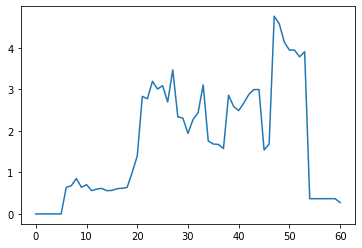

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4941527804433745,
 'clustered_split_factor': 924,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd62ac91a60>,
 'fit_shape': (1012, 2),
 'split': 'location_device',
 'split_variance': 0.9617579547916049}


,sessions,rps
clust,,
0.0,11954,3.016575
1.0,459,2.453950
2.0,396,2.241232
3.0,320,2.501411
4.0,1299,2.489991
...,...,...
59.0,67,4.695821
60.0,110,3.295182
61.0,578,2.613780


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

state_clust     0
dma_clust       0
device_clust    0
utc_dt          0
dtype: int64

state_clust       0
dma_clust       875
device_clust      0
utc_dt            0
dtype: int64

<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (39334, 106)
|--- x2_0.0 <= 0.50
|   |--- x2_1.0 <= 0.50
|   |   |--- value: [2.44]
|   |--- x2_1.0 >  0.50
|   |   |--- value: [2.02]
|--- x2_0.0 >  0.50
|   |--- value: [2.91]

Tree RPS MAE: 3.106244164337264
|X| (39334, 106)
|X| (18494, 106)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38154158080122824,
 'clustered_split_factor': 153,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd64495ce20>,
 'fit_shape': (1012, 2),
 'split': 'location_device',
 'split_variance': 0.9617579547916049}


,sessions,rps
clust,,
2,11263,2.845949
3,194858,2.413007
4,102063,3.229121


<ipython-input-191-07dd5adef3f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (59, 2),
 'cluster_variance': 0.5710492412792437,
 'clustered_split_factor': 2403,
 'clusterer': <__main__.AggRPSClust object at 0x7fd62fb7a5e0>,
 'fit_shape': (2631, 2),
 'split': 'location_os_device',
 'split_variance': 1.3097098228816146}


,sessions,rps
clust,,
0.0,6245,1.779276
1.0,2,0.000000
2.0,6,2.775000
3.0,915,3.386120
4.0,89,6.541694
5.0,10512,3.549028
6.0,4,0.000000
7.0,28,4.936071
8.0,1619,2.780276


state               0
dma                 0
operating_system    0
device              0
utc_dt              0
dtype: int64

state                 0
dma                 751
operating_system      7
device                0
utc_dt                0
dtype: int64

|X| (67820, 259)
|--- x3_DESK <= 0.50
|   |--- x3_PHON <= 0.50
|   |   |--- value: [2.44]
|   |--- x3_PHON >  0.50
|   |   |--- x2_iOS <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x2_iOS >  0.50
|   |   |   |--- value: [1.98]
|--- x3_DESK >  0.50
|   |--- x2_Mac OS X <= 0.50
|   |   |--- value: [3.01]
|   |--- x2_Mac OS X >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 3.417165685087465
|X| (67820, 259)
|X| (32765, 259)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.3862842509748333,
 'clustered_split_factor': 654,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd6466fca60>,
 'fit_shape': (2631, 2),
 'split': 'location_os_device',
 'split_variance': 1.3097098228816146}


,sessions,rps
clust,,
2,11263,2.845949
4,67618,2.473588
5,127230,2.381001
7,72439,3.284192
8,29624,3.094457


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


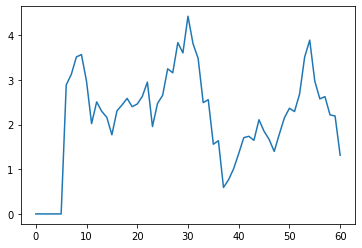

<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.430367188860001,
 'clustered_split_factor': 2526,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd644f89880>,
 'fit_shape': (2631, 2),
 'split': 'location_os_device',
 'split_variance': 1.3097098228816146}


,sessions,rps
clust,,
0.0,342,1.821533
1.0,14752,2.291371
2.0,1464,2.863253
3.0,8383,3.019182
4.0,657,3.407218
...,...,...
59.0,6629,1.932981
60.0,814,3.359778
61.0,290,1.718091


<ipython-input-193-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-191-07dd5adef3f3>:131: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-191-07dd5adef3f3>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

state_clust               0
dma_clust                 0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

state_clust                 0
dma_clust                 295
operating_system_clust      7
device_clust                0
utc_dt                      0
dtype: int64

|X| (67820, 119)
|--- x3_0.0 <= 0.50
|   |--- x3_1.0 <= 0.50
|   |   |--- value: [2.44]
|   |--- x3_1.0 >  0.50
|   |   |--- x2_5.0 <= 0.50
|   |   |   |--- value: [2.10]
|   |   |--- x2_5.0 >  0.50
|   |   |   |--- value: [1.98]
|--- x3_0.0 >  0.50
|   |--- x2_2.0 <= 0.50
|   |   |--- value: [3.01]
|   |--- x2_2.0 >  0.50
|   |   |--- value: [2.68]

Tree RPS MAE: 3.4171656850874648
|X| (67820, 119)
|X| (32765, 119)


<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-191-07dd5adef3f3>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.3862842509748333,
 'clustered_split_factor': 654,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd6449a5ca0>,
 'fit_shape': (2631, 2),
 'split': 'location_os_device',
 'split_variance': 1.3097098228816146}


,sessions,rps
clust,,
2,11263,2.845949
4,67618,2.473588
5,127230,2.381001
7,72439,3.284192
8,29624,3.094457


,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
0,AggRPSClust,<__main__.AggRPSClust object at 0x7fd62b73fd30>,browser,"(3, 2)","(2, 2)",0.008421,0.006876,6
1,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd62b73ffa0>,browser,"(3, 2)","(1, 2)",0.008421,0.000000,1
2,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd644b1b520>,browser,"(3, 2)","(2, 2)",0.008421,0.006876,6
3,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,browser,"(3, 2)","(1, 2)",0.008421,0.000000,1
4,AggRPSClust,<__main__.AggRPSClust object at 0x7fd62b311d60>,operating_system,"(8, 2)","(6, 2)",0.354250,0.354217,11
...,...,...,...,...,...,...,...,...
63,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,location_device,"(1012, 2)","(3, 2)",0.961758,0.381542,153
64,AggRPSClust,<__main__.AggRPSClust object at 0x7fd62fb7a5e0>,location_os_device,"(2631, 2)","(59, 2)",1.309710,0.571049,2403
65,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd6466fca60>,location_os_device,"(2631, 2)","(5, 2)",1.309710,0.386284,654
66,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd644f89880>,location_os_device,"(2631, 2)","(64, 2)",1.309710,0.430367,2526


In [193]:
perfD = []
for split,rps_df in split2aggrps.items():
    
    rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
    rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
    rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
    rps_df["rps"] = rps_df["rps_avg"]
    fitI = rps_df.reset_index()['utc_dt'] < eval_date
    fitI.index = rps_df.index

    for clust_mtd in [AggRPSClust,TreeRPSClust,KpiCorrClust,HybridCorrTreeClust]:
        clusterer = clust_mtd().fit(rps_df[fitI],None)
        rps_df["clust"] = -1
        rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
        rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

        agg_rps_df = rps_df \
            [~fitI] \
            .groupby(rps_df.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        clust_rps_df = rps_df \
            [~fitI] \
            .groupby("clust") \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })

        assert clust_rps_df["rps"].max() <= agg_rps_df["rps"].max()
        rps_wavg = wavg(agg_rps_df[["rps"]], agg_rps_df["sessions"])
        rps_clust_wavg = wavg(clust_rps_df[["rps"]], clust_rps_df["sessions"])
        assert all((rps_wavg - rps_clust_wavg).abs() < 1e-2), (rps_wavg, rps_clust_wavg)


        perfd = {
            "clust_mtd": clusterer.__class__.__name__,
            "clusterer": clusterer,
            "split": split,
            "fit_shape": agg_rps_df.shape,
            "clust_shape": clust_rps_df.shape,
            "split_variance": wstd(agg_rps_df["rps"], agg_rps_df["sessions"]),
            "cluster_variance": wstd(clust_rps_df["rps"], clust_rps_df["sessions"]),
            # wstd(rps_df["rps_avg"],rps_df["sessions"])
            "clustered_split_factor": get_split_factor(rps_df),
        }
        perfD.append(perfd)
        pprint.pprint(perfd)
        ipydisp(clust_rps_df)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)

In [194]:
perfdf.tail(50)

,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
18,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd62fab3370>,TOD,"(672, 2)","(64, 2)",0.700971,0.450706,302
19,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,TOD,"(672, 2)","(3, 2)",0.700971,0.216179,7
20,AggRPSClust,<__main__.AggRPSClust object at 0x7fd62b2ff580>,dma,"(210, 2)","(64, 2)",0.583362,0.502169,64
21,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd62f86ffd0>,dma,"(210, 2)","(1, 2)",0.583362,0.000000,1
22,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd62c6527f0>,dma,"(210, 2)","(64, 2)",0.583362,0.489301,64
23,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,dma,"(210, 2)","(1, 2)",0.583362,0.000000,1
24,AggRPSClust,<__main__.AggRPSClust object at 0x7fd62a2c2fd0>,state,"(51, 2)","(51, 2)",0.529218,0.529218,51
25,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd62fbb8df0>,state,"(51, 2)","(1, 2)",0.529218,0.000000,1
26,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd62fbb8730>,state,"(51, 2)","(51, 2)",0.529218,0.529218,51
27,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,state,"(51, 2)","(1, 2)",0.529218,0.000000,1


In [242]:
split,clusterer = perfdf.loc[27,["split","clusterer"]]
print("split:",split)
rps_df = split2aggrps[split]
rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df["rps"] = rps_df["rps_avg"]
fitI = rps_df.reset_index()['utc_dt'] < eval_date
fitI.index = rps_df.index

rps_df["clust"] = -1
rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) 
                          for index_col in rps_df.index.names[:-1]}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df.reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: lambda seq: tuple(set(seq))
    }) \
    .sort_index()

assert campaign_df["sessions"].sum() == rps_df["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df["rps_avg"], rps_df["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

|X| (4176, 19)
|X| (2227, 19)


In [246]:
camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "INCLUDE": r[last_field]
    }
    camps.append(camp)

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] \
    .apply(flatten)
for idx, r in excl_campaign_df.iterrows():
    camp = {}
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "EXCLUDE": r[last_field]
    }
    camps.append(camp)

camp_attr_df = pd.DataFrame(camps)
camp_attr_df.to_csv("campaign_dump.csv")
camp_attr_df

,sessions_60d,rps_avg_60d,device,operating_system,state
0,9.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('NY', 'FL', 'CA')}"
1,1.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('VA',)}"
2,2.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('TX',)}"
3,535.0,0.340172,{'INCLUDE': 'DESK'},{'INCLUDE': 'Linux'},"{'INCLUDE': ('OK', 'PA', 'AZ', 'RI', 'MN', 'ND..."
4,161.0,0.036894,{'INCLUDE': 'DESK'},{'INCLUDE': 'Linux'},"{'INCLUDE': ('NY',)}"
...,...,...,...,...,...
80,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Linux'},"{'EXCLUDE': ('OK', 'PA', 'AZ', 'RI', 'MN', 'ND..."
81,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Mac OS X'},"{'EXCLUDE': ('OK', 'PA', 'NJ', 'MI', 'DE', 'MD..."
82,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Windows'},"{'EXCLUDE': ('AZ', 'DC', 'WA', 'OH', 'GA', 'NC')}"
83,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'iOS'},"{'EXCLUDE': ('WI', 'OH', 'TX')}"


In [147]:
import json

TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

from pytaboola.services import AccountService
from pytaboola.services import CampaignService

import itertools
import tqdm
import pandas as pd
import os
from pkg_resources import resource_filename as rscfn


acct_service = AccountService(client)
accnts = acct_service.list()["results"]
NETWORK_ACCNT_ID = "healthcareinc-network"
TEST_ACCNT_ID = "healthcareinc-sc2"
O65_ACCNT_ID = "taboolaaccount-rangaritahealthcarecom"
id2accnt = {a["account_id"]: a for a in accnts}

def accnt_camps(accnt):
    camp_service = CampaignService(client, accnt["account_id"])
    return camp_service.list()
aid2cid2camp = {}
for aid,a in tqdm.tqdm(id2accnt.items()):
    cid2camp = {c["id"]: c for c in accnt_camps(a)}
    aid2cid2camp[aid] = cid2camp

import json
json.dump(aid2cid2camp, open("camps.json", "w"))
O65_accnt_camps = accnt_camps(id2accnt[O65_ACCNT_ID])
print("|065_accnt_camps|:",len(O65_accnt_camps))

test_accnt_camps = accnt_camps(id2accnt[TEST_ACCNT_ID])
print("|test_accnt_camps|",len(test_accnt_camps))

import itertools
cross = itertools.product
import jmespath
get = jmespath.search

active_camps = get(
  "*.*[] | [?is_active]",
  aid2cid2camp,
)
print("|active campaigns|:",len(active_camps))

100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


|065_accnt_camps|: 100


In [261]:
def taboola_targetting_fields(r):
    def pivot(o):
        (t,v),*_ = o.items()
        return {
            "type": t,
            "value": [*v] if isinstance(v,(list,tuple,set)) else [v]
        }
    targetting_fields = {}
    if "device" in r:
        targetting_fields["platform_targeting"] = pivot(r["device"])
    if "state" in r:
        targetting_fields["sub_country_targeting"] = pivot(r["state"])
    if "dma" in r:
        targetting_fields["dma_country_targeting"] = pivot(r["dma"])
    if "operating_system" in r:
        (t,v),*_ = r["operating_system"].items()
        targetting_fields["os_targeting"] = {
            "type": "INCLUDE",
            "value": [
                {
                    "os_family": v
                },
            ],
        }
    return targetting_fields
ipydisp(camp_attr_df.apply(taboola_targetting_fields,axis=1).head())
taboola_targetting_fields(camp_attr_df.iloc[0,:])

0    {'platform_targeting': {'type': 'INCLUDE', 'va...
1    {'platform_targeting': {'type': 'INCLUDE', 'va...
2    {'platform_targeting': {'type': 'INCLUDE', 'va...
3    {'platform_targeting': {'type': 'INCLUDE', 'va...
4    {'platform_targeting': {'type': 'INCLUDE', 'va...
dtype: object

{'platform_targeting': {'type': 'INCLUDE', 'value': ['DESK']},
 'sub_country_targeting': {'type': 'INCLUDE', 'value': ['NY', 'FL', 'CA']},
 'os_targeting': {'type': 'INCLUDE', 'value': [{'os_family': 'Android'}]}}

In [269]:
src_accnt = id2accnt[O65_ACCNT_ID]
src_camp = active_camps[0]
dest_accnt = id2accnt[TEST_ACCNT_ID]

client = TaboolaClient(**TABOOLA_HC_CREDS)
client.authorization_header,client.token_details

resp = requests.post(
    f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
    json={
        "name": src_camp["id"],
        "start_date": (TODAY + 2*DAY).__str__(),
        **taboola_targetting_fields(camp_attr_df.iloc[0]),
    },
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

HTTPError: 400 Client Error: Bad Request for url: https://backstage.taboola.com/backstage/api/1.0/taboolaaccount-rangaritahealthcarecom/campaigns/10798231/duplicate?destination_account=healthcareinc-sc2

In [ ]:
# import requests
# TODAY = NOW.date()
# TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
# for src_camp in active_camps:
#     src_accnt = id2accnt[O65_ACCNT_ID]
#     dest_accnt = id2accnt[TEST_ACCNT_ID]

#     client = TaboolaClient(**TABOOLA_HC_CREDS)
#     client.authorization_header,client.token_details

#     for _,camp_attrs in camp_attr_df.iterrows():
#         resp = requests.post(
#             f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
#             json={
#                 "name": src_camp["id"],
#                 "start_date": (TODAY + 2*DAY).__str__(),
#                 **taboola_targetting_fields(camp_attrs),
#             },
#             params= {
#                 "destination_account": dest_accnt["account_id"],
#             },
#             headers=client.authorization_header,)
#         resp.raise_for_status()

#         new_camp = resp.json()

In [165]:
import json
TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

import requests
import jmespath
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/operating_systems",
    headers=client.authorization_header)
taboola_os = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/platforms",
    headers=client.authorization_header)
taboola_platforms = jmespath.search('results[].name', resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/dma",
    headers=client.authorization_header)
taboola_dmas = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/regions",
    headers=client.authorization_header)
taboola_states = jmespath.search('results[].name',resp.json(),)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))

In [ ]:
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()